## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

In [2]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [3]:
# your code here
# taking the logarithm
Data1['AvgDailyTrafficCount'] = np.log(Data1['AvgDailyTrafficCount'])
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,4.430817
1,-80.162117,40.384598,4.553877
2,-80.221205,40.366778,4.574711
3,-80.142455,40.622084,4.709530
4,-80.131975,40.544915,4.828314


In [4]:
x = Data1[['Longitude', 'Latitude']].values
y = Data1['AvgDailyTrafficCount'].values

In [5]:
kernel = 10.* RBF(length_scale=(0.1,0.1), length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10)) + 100

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

gp.fit(x, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=3.16**2 * RBF(length_scale=[0.1, 0.1]) + WhiteKernel(noise_level=1) + 10**2,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=1)

In [6]:
print gp.log_marginal_likelihood_value_
print gp.kernel_

-1367.48883088
0.65**2 * RBF(length_scale=[0.0326, 0.0398]) + WhiteKernel(noise_level=0.568) + 8.19**2


In [7]:
# Mesh grid plot
h = .02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gp.fit(x, y)

# create a mesh to plot in
x_min, x_max = x[:, 0].min() - 0.02, x[:, 0].max() + 0.02
y_min, y_max = x[:, 1].min() - 0.02, x[:, 1].max() + 0.02

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


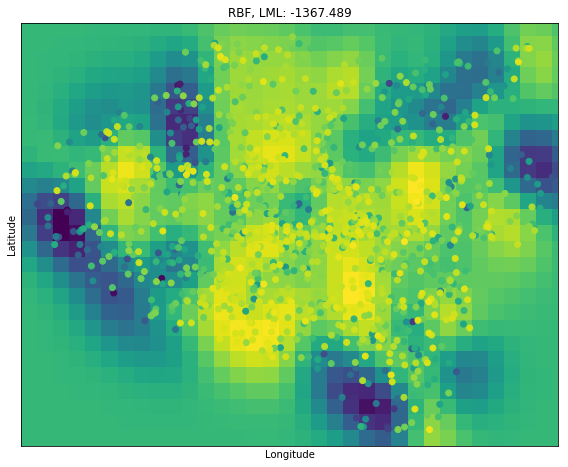

In [8]:
plt.figure(figsize=(8, 8))
    # Plot the predicted values. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], c=np.squeeze(y))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gp.log_marginal_likelihood(gp.kernel_.theta)))

plt.tight_layout()
plt.show()

In [9]:
# (4)
y_pred = gp.predict(x)
y_pred

array([ 6.82262503,  7.60586968,  7.08757705, ...,  8.9128905 ,
        8.6935152 ,  9.06547033])

In [10]:
y = pd.DataFrame(y)
y['prediction'] = y_pred
y.columns = [['observation', 'prediction']]
y.head()

,observation,prediction
0,4.430817,6.822625
1,4.553877,7.605870
2,4.574711,7.087577
3,4.709530,7.103782
4,4.828314,7.071933


In [11]:
# calculating the standard deviation of the prediction values
std = y.prediction.std()
std

0.52859957584302675

In [12]:
# percentage of the sensors that satisfies the criteria
count = 0

for i in range(len(y.prediction)):
    if y.observation[i] < y.prediction[i] - 2*std:
        count = count + 1;
    elif y.observation[i] > y.prediction[i] + 2*std:
        count = count + 1;

print "{}% of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location".format((float(count)/len(y.observation))*100)

11.9282511211% of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location


5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

In [13]:
# (5)
# more than two standard deviations higher than predicted
a = Data1[Data1['AvgDailyTrafficCount'] > y.prediction + 2*std]

In [14]:
# more than two standard deviations lower than predicted
b = Data1[Data1['AvgDailyTrafficCount'] < y.prediction - 2*std]

In [15]:
# within two standard deviations of the predicted values
c = Data1[(Data1['AvgDailyTrafficCount']>y.prediction-2*std)
          &(Data1['AvgDailyTrafficCount']<y.prediction+2*std)]

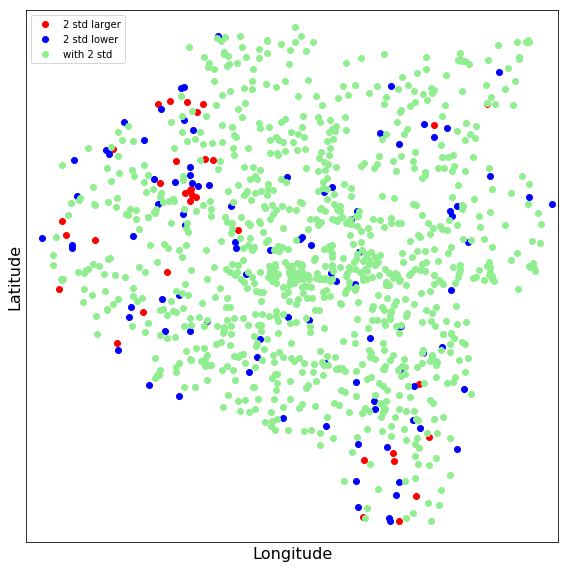

In [16]:
plt.figure(figsize=(8,8))

# Plot also the training points
plt.scatter(a.iloc[:,0], a.iloc[:,1], c='red')
plt.scatter(b.iloc[:,0], b.iloc[:,1], c='blue')
plt.scatter(c.iloc[:,0], c.iloc[:,1], c='lightgreen')
plt.xlabel('Longitude', fontsize = 16)
plt.ylabel('Latitude', fontsize = 16)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

L=plt.legend()
L.get_texts()[0].set_text('2 std larger')
L.get_texts()[1].set_text('2 std lower')
L.get_texts()[2].set_text('with 2 std')
plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### Your solution here

<font face="Times New Roman" color=#666666 size=4>I think it would be helpful to clarify how the specific cluster standard deviation for marking given data would be calculated.    
<br>      
Use the following method: Calculate the distance from each point in the given cluster to the center of the cluster, and take the average of these distances. Then we can get the standard deviation of the calculated distance.    
    <br>  
Because geometrically, whether a point belongs to a cluster is to see if this point falls into a circle centered on the cluster center and the standard deviation is a radius.    <br>   
therefore:</font>

<font face="Times New Roman" color=#666666 size=4>
(1,0) is Anomaly    
Since the distance from (1,0) to (0,0) is greater than the standard deviation of 0.1. <br>  
     
(35, 2) is not abnormal    
Since the distance from (35,2) to (35,5) is less than the standard deviation of 5.
<br>  
(15,19)      anomaly    
because it is closest to the smallest cluster with only 2 points.
<br>  

(10, 11) is not abnormal    
Because the distance from (10,11) to (10,10) is not greater than the standard deviation of 1.
</font>

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [17]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [18]:
Data2.shape

(3141, 31)

In [19]:
# your code here
# Part 1
# selecting the six variables
short = Data2[ ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'",
                "'\% Children in Poverty'","'Average Daily PM2.5'"]]
short.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,19,31,254,4.3,18,12.9
1,19,27,221,4.5,20,13.1
2,21,41,147,5.3,38,12.6
3,21,40,236,4.3,27,12.9
4,19,32,219,4.1,24,12.7


In [20]:
# data pre-processing: converting all numerical values to float data type
short.dtypes

'\% Smokers'                object
'\% Obese'                   int64
'Violent Crime Rate'        object
'80/20 Income Ratio'        object
'\% Children in Poverty'    object
'Average Daily PM2.5'       object
dtype: object

In [21]:
short = short.convert_objects(convert_numeric=True)
short["'\% Obese'"] = short["'\% Obese'"].astype("float64")
short.dtypes

C:\Users\xihao\Anaconda2\envs\pgmpy-env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


'\% Smokers'                float64
'\% Obese'                  float64
'Violent Crime Rate'        float64
'80/20 Income Ratio'        float64
'\% Children in Poverty'    float64
'Average Daily PM2.5'       float64
dtype: object

In [22]:
# check whether there is infinite values in the dataframe
np.isfinite(short.values).all()

False

In [23]:
# to see whether there are na values
short.isnull().any()

'\% Smokers'                 True
'\% Obese'                  False
'Violent Crime Rate'         True
'80/20 Income Ratio'         True
'\% Children in Poverty'     True
'Average Daily PM2.5'        True
dtype: bool

In [24]:
# dropping na values
short = short.dropna(subset = ["'\% Smokers'", "'Violent Crime Rate'", "'80/20 Income Ratio'", "'\% Children in Poverty'",
                       "'Average Daily PM2.5'"])

In [25]:
short.isnull().any()

'\% Smokers'                False
'\% Obese'                  False
'Violent Crime Rate'        False
'80/20 Income Ratio'        False
'\% Children in Poverty'    False
'Average Daily PM2.5'       False
dtype: bool

In [26]:
# discretizing the columns
for i in short.columns:
    short[i] = pd.cut(short[i], 5, labels = [0,1,2,3,4])

short.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,1,2,0,1,1,3
1,1,2,0,1,1,3
2,2,4,0,2,3,3
3,2,4,0,1,2,3
4,1,2,0,1,1,3


In [27]:
short.dtypes

'\% Smokers'                category
'\% Obese'                  category
'Violent Crime Rate'        category
'80/20 Income Ratio'        category
'\% Children in Poverty'    category
'Average Daily PM2.5'       category
dtype: object

In [28]:
for i in short.columns:
    short[i] = short[i].astype("int64")

short.dtypes

'\% Smokers'                int64
'\% Obese'                  int64
'Violent Crime Rate'        int64
'80/20 Income Ratio'        int64
'\% Children in Poverty'    int64
'Average Daily PM2.5'       int64
dtype: object

In [29]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

In [30]:
hc = HillClimbSearch(short, scoring_method=BicScore(short))
best_model = hc.estimate()
print(best_model.edges())

[("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Smokers'", "'\\% Obese'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'\\% Smokers'")]


In [31]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(short, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of '80/20 Income Ratio':
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '\% Children in Poverty' | '\% Children in Poverty'(0) | '\% Children in Poverty'(1) | '\% Children in Poverty'(2) | '\% Children in Poverty'(3) | '\% Children in Poverty'(4) |
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '80/20 Income Ratio'(0)  | 0.416909620991              | 0.182634730539              | 0.0479233226837             | 0.016835016835              | 0.0                         |
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '80/20 Income Ratio'(1)  | 0.530612244898              | 0.74625748503    

In [32]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

In [33]:
results = short.apply(lambda x: LL(x,model),axis=1)

In [34]:
# 5 most anomalous data records
anomaly = results.sort_values().head(20)
print anomaly.head(5)

1856   -15.242954
1227   -15.218920
221    -15.209478
317    -13.826869
2027   -13.794734
dtype: float64


In [36]:
counties = Data2[Data2.index.isin(anomaly.index)]['County']
counties.head(5)

221                     San Francisco, California
248                             Boulder, Colorado
317    District of Columbia, District of Columbia
415                              Clayton, Georgia
444                               Fulton, Georgia
Name: County, dtype: object

In [37]:
# printing the list of counties that have the lowest log likelihood values
df1 = counties.to_frame()
df2 = anomaly.to_frame()
final_list1 = df1.join(df2)
final_list1.columns = ['County', 'Log Likelihood']
final_list1 = final_list1.sort_values(by=['Log Likelihood'])
final_list1.head(5)

,County,Log Likelihood
1856,"New York, New York",-15.242954
1227,"Suffolk, Massachusetts",-15.218920
221,"San Francisco, California",-15.209478
317,"District of Columbia, District of Columbia",-13.826869
2027,"Rolette, North Dakota",-13.794734


In [38]:
# Part 2
# (a) K MEANS clustering
Data2.dtypes

County                                    object
'\% Reporting Fair/Poor Health'           object
'Physically Unhealthy Days Per Month'     object
'Mentally Unhealthy Days Per Month'       object
'\% Low birth weight births'              object
'\% Smokers'                              object
'\% Obese'                                 int64
'Food Environment Index'                 float64
'\% Physically Inactive'                   int64
'\% With Access To Exercise'              object
'\% Excessive Drinking'                   object
'\% Alcohol-Impaired Driving Deaths'      object
'Chlamydia Rate'                          object
'Teen Birth Rate'                         object
'\% Uninsured'                            object
'Preventable Hosp. Rate'                  object
'\% Dibetics receiving HbA1c'             object
'\% Mammography'                          object
'Graduation Rate'                         object
'\% Some College'                         object
'\% Unemployed'     

In [39]:
# Converting data type to float
Data2 = Data2.convert_objects(convert_numeric=True)
Data2["'\% Obese'"] = Data2["'\% Obese'"].astype("float64")
Data2["'\% Physically Inactive'"] = Data2["'\% Physically Inactive'"].astype("float64")
Data2["'\% Severe Housing Problems'"] = Data2["'\% Severe Housing Problems'"].astype("float64")

Data2.dtypes

C:\Users\xihao\Anaconda2\envs\pgmpy-env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


County                                    object
'\% Reporting Fair/Poor Health'          float64
'Physically Unhealthy Days Per Month'    float64
'Mentally Unhealthy Days Per Month'      float64
'\% Low birth weight births'             float64
'\% Smokers'                             float64
'\% Obese'                               float64
'Food Environment Index'                 float64
'\% Physically Inactive'                 float64
'\% With Access To Exercise'             float64
'\% Excessive Drinking'                  float64
'\% Alcohol-Impaired Driving Deaths'     float64
'Chlamydia Rate'                         float64
'Teen Birth Rate'                        float64
'\% Uninsured'                           float64
'Preventable Hosp. Rate'                 float64
'\% Dibetics receiving HbA1c'            float64
'\% Mammography'                         float64
'Graduation Rate'                        float64
'\% Some College'                        float64
'\% Unemployed'     

In [40]:
X = Data2.iloc[:,1:]
X = X.values
X

array([[ 19. ,   4.4,   4.3, ...,  14. ,  89. ,  42. ],
       [ 16. ,   4.1,   4.2, ...,  15. ,  84. ,  37. ],
       [ 26. ,   4.9,   4.7, ...,  18. ,  84. ,  35. ],
       ..., 
       [ 15. ,   3.4,   3.2, ...,  12. ,  78. ,  17. ],
       [ 14. ,   3.3,   3.3, ...,   9. ,  70. ,  12. ],
       [ 13. ,   3.3,   3.1, ...,   8. ,  68. ,  22. ]])

In [41]:
# converting all NAN values to numeric values
X = np.nan_to_num(X)

In [42]:
# no NA in the data
np.isfinite(X).all()

True

In [43]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(X)

# distance to each cluster center
res=pd.DataFrame(KM.transform(X))
res.head()

,0,1,2
0,250.946004,105.535695,630.921505
1,144.131528,190.129811,740.514207
2,438.079611,282.740781,541.825251
3,202.050419,144.578630,681.692113
4,107.417221,318.099738,874.794703


In [44]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res_ind = res.sort_values("score",ascending=False)[:20]
res_ind.head(5)

,0,1,2,cluster,score
2415,2468.948749,2249.197299,1808.542199,2,1808.542199
82,2243.246976,2025.872187,1595.761604,2,1595.761604
90,2228.863484,2012.658893,1585.523000,2,1585.523000
84,2207.055249,1990.245057,1562.359305,2,1562.359305
2379,2068.136787,1850.605374,1425.727411,2,1425.727411


In [45]:
KMC = Data2[Data2.index.isin(res_ind.index)]['County']
df3 = KMC.to_frame()
df4 = res_ind['score'].to_frame()
final_list2 = df3.join(df4)
final_list2.columns = ['County', 'KMEANS score']
final_list2 = final_list2.sort_values(by=['KMEANS score'], ascending=False)
final_list2.head(5)

,County,KMEANS score
2415,"Shannon, South Dakota",1808.542199
82,"Nome, Alaska",1595.761604
90,"Wade Hampton, Alaska",1585.523000
84,"Northwest Arctic, Alaska",1562.359305
2379,"Dewey, South Dakota",1425.727411


In [46]:
# (b) GM clustering
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [47]:
# 5 most anomalous data points by log-likelihood (i.e. log probability density)
GMA = pd.DataFrame(GM.score_samples(X)).sort_values(0)[:20]
GMA.head(5)

,0
2914,-245.937199
546,-201.862761
2671,-162.732278
2651,-160.939796
1749,-135.167379


In [48]:
CGM = Data2[Data2.index.isin(GMA.index)]['County']
A = CGM.to_frame()
final_list3 = A.join(GMA)
final_list3.columns = ['County', 'GM Log Likelihood']
final_list3 = final_list3.sort_values(by=['GM Log Likelihood'])
final_list3.head(5)

,County,GM Log Likelihood
2914,"Bedford City, Virginia",-245.937199
546,"Kalawao, Hawaii",-201.862761
2671,"Loving, Texas",-162.732278
2651,"Kenedy, Texas",-160.939796
1749,"Esmeralda, Nevada",-135.167379


In [49]:
# Part 3
# Method Chosen: isolation forest
from sklearn.ensemble import IsolationForest

In [50]:
X = Data2.iloc[:,1:]
X = np.nan_to_num(X)
X

array([[ 19. ,   4.4,   4.3, ...,  14. ,  89. ,  42. ],
       [ 16. ,   4.1,   4.2, ...,  15. ,  84. ,  37. ],
       [ 26. ,   4.9,   4.7, ...,  18. ,  84. ,  35. ],
       ..., 
       [ 15. ,   3.4,   3.2, ...,  12. ,  78. ,  17. ],
       [ 14. ,   3.3,   3.3, ...,   9. ,  70. ,  12. ],
       [ 13. ,   3.3,   3.1, ...,   8. ,  68. ,  22. ]])

In [51]:
# fit the model
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X)
y_pred_train = clf.predict(X)

In [52]:
score = clf.decision_function(X)

In [53]:
Data2['clf_score'] = score
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone',clf_score
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,...,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0,0.113433
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,...,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0,0.121597
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,...,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0,0.029309
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,...,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0,0.102213
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,...,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0,0.088336


In [54]:
# Isolation forest: top 5 most anomalous counties
final_list4 = Data2.sort_values(by=['clf_score'], ascending=True)[['County','clf_score']].head(20)
final_list4.head(5)

,County,clf_score
90,"Wade Hampton, Alaska",-0.143673
2415,"Shannon, South Dakota",-0.133228
80,"Lake and Peninsula, Alaska",-0.118162
70,"Bethel, Alaska",-0.114585
84,"Northwest Arctic, Alaska",-0.106054


In [55]:
# Part 4
# Bayesian network: top 5 anomalies
f1 = final_list1.head(5)
f1

,County,Log Likelihood
1856,"New York, New York",-15.242954
1227,"Suffolk, Massachusetts",-15.218920
221,"San Francisco, California",-15.209478
317,"District of Columbia, District of Columbia",-13.826869
2027,"Rolette, North Dakota",-13.794734


In [56]:
# K means clustering: top 5 anomalies
f2 = final_list2.head(5)
f2

,County,KMEANS score
2415,"Shannon, South Dakota",1808.542199
82,"Nome, Alaska",1595.761604
90,"Wade Hampton, Alaska",1585.523000
84,"Northwest Arctic, Alaska",1562.359305
2379,"Dewey, South Dakota",1425.727411


In [57]:
# GM clustering: top 5 anomalies
f3 = final_list3.head(5)
f3

,County,GM Log Likelihood
2914,"Bedford City, Virginia",-245.937199
546,"Kalawao, Hawaii",-201.862761
2671,"Loving, Texas",-162.732278
2651,"Kenedy, Texas",-160.939796
1749,"Esmeralda, Nevada",-135.167379


In [58]:
# Isolation Forest: top 5 anomalies
f4 = final_list4.head(5)
f4

,County,clf_score
90,"Wade Hampton, Alaska",-0.143673
2415,"Shannon, South Dakota",-0.133228
80,"Lake and Peninsula, Alaska",-0.118162
70,"Bethel, Alaska",-0.114585
84,"Northwest Arctic, Alaska",-0.106054


ANSWER: Yes, there are many counties which are found to be anomalous by one model but not anomalous by other model. Actually only the result of K means clustering and that of isolation forest have there overlapping counties. The other methods yields complete different results from each other. 

In [59]:
# Counties that are labeled anomalous by both K means and isolation forest
both = f2.index.intersection(f4.index)
f2[f2.index.isin(both)]['County']

2415       Shannon, South Dakota
90          Wade Hampton, Alaska
84      Northwest Arctic, Alaska
Name: County, dtype: object